# Ансамбли моделей
## Предисловие
Как Вы уже знаете, модели МО можно использовать не только "как есть", но ещё и строить разнообразные надстройки над ними. Хорошей идеей такой надстройки было и остаётся объединение моделей в ансамбль.

Сама суть ансамблей заключается в том, чтобы объединить предсказания стандартных моделей для повышения обощающей способности или надёжности ансамбля перед одиночным стандартным методом МО.

Ансамбли делятся на два типа:

- Голосующие (или усредняющие) - смысл их заключается в том, чтобы сначала обучить независимые друг от друга модели, а затем голосованием этих моделей выбирать предсказание (или усреднять предсказания по всем моделям, зависит от задачи). Обычно, качество предсказания у ансамблей лучше потому, что у них понижена дисперсия.

    Примеры: [Бэггинг](https://scikit-learn.org/stable/modules/ensemble.html#bagging), [Случайный лес](https://scikit-learn.org/stable/modules/ensemble.html#forest)

- Бустинг-ансамбли - последовательности стандартных моделей, построенные так, чтобы каждая последующая добавленная и натренированная модель каким-то образом исправляла ошибки всей предшествующей ей последовательности моделей. "Объединение слабых моделей даёт сильную модель".

    Примеры: [AdaBoost](https://scikit-learn.org/stable/modules/ensemble.html#adaboost), [Градиентный бустинг](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting)

Полная [документация](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble) по доступным в sklearn ансамблям.
[Урок](https://habr.com/ru/company/ods/blog/327250/) про бустинг из курса хабра.


## Задача
На этом воркшопе мы будем реализовывать алгоритм градиентного бустинга. Напомню, что в общем смысле бустинг заключается в том, чтобы тренировать каждую последующую модель так, чтобы она исправляла ошибки предыдущих.

Прежде чем мы приступим к реализации, давайте вспомним, как он устроен:
Краткое описание [оригинального алгоритма](https://statweb.stanford.edu/~jhf/ftp/stobst.pdf) (который придумал Фридман):
Для работы алгоритма помимо данных нужно подать:
1. количество итераций $M \in \mathbb{N}$;
2. функцию потерь $L(y,f)$, где $y$ - истинные значения, $f$ - полученная аппроксимация искомой функции (в данном случае это будет не функция, а просто предсказанные значения).
Важно, чтобы функция потерь была дифференцируемой по $f$;
3. базовая модель, на основе которой мы будем делать бустинг - в данном воркшопе мы воспользуемся деревьями решений;
4. Начальное приближение $f_0(x)$ - чаще всего для этого используют некую константу.

**Сам алгоритм:**
1. Задаём начальное приближение функции $f(x) = f_0(x)$ константой - в данном случае можно выбрать ноль, среднее по столбцу с целевым признаком или что-нибудь ещё.
2. Далее итеративно $t$ от 1 до $M$: 
    1. Считаем остатки как $\large r_{t} = -\left[\frac{\partial L(y, f(x))}{\partial f(x)}\right]_{f(x)=\hat{f}(x)}$
    2. Обучаем ещё одну базовую модель $h_t(x)$, при этом нецелевыми признаками у нас будет $x$, а в качестве целевого будем использовать остатки $r_t$, полученные на текущем шаге
    3. Найти оптимальный коэффициент $\rho_t = \underset{\rho}{\arg\min} \ L(y, \hat{f}(x) + \rho \cdot h(x))$ 
    4. обновить текущее приближение $\hat{f}(x) \leftarrow \hat{f}(x) + \hat{f}_i(x)$, где $\hat{f}_i(x) = \rho_t \cdot h_t(x)$
3. Собрать все полученные базовые алгоритмы в модель $\hat{f}(x) = \sum_{i = 0}^M \hat{f_i}(x)$

**Функции потерь:**
- $L(y, f) = \frac{1}{2}(y - f)^2$ - _MSE-loss_. Используйте его если считаете, что у модели нет никаких дополнительных требований к стабильности.
- $L(y, f) = |y - f|$ - _MAE-loss_. Применять при требованиях к стабильности модели. Из минусов можно выделить то, что её немного сложнее дифференцировать (придётся искать производные на разных кусках)
- $\begin{equation} L(y, f) =\left\{ \begin{array}{@{}ll@{}} (1 - \alpha) \cdot |y - f|, & \largeесли\ y-f \leq 0 \\ \alpha \cdot |y - f|, & \largeесли\ y-f >0 \end{array}\right. \end{equation}, \alpha \in (0,1)$ - $L_q$-loss. Применять при наличии особых требований к модели, например, когда нам нужно восстановить не среднее и не медиану условного распределения $(y|x)$, а какую-нибудь квантиль. Штрафует наблюдения, попадающие выше $\alpha$-той квантили.

**Замечание:**
1. коэффициенты $\rho_i$ искать не обязательно, их можно считать равными единице
2. функции потерь для регрессии бывают 3 видов, Вам достаточно реализовать хотя бы одну из них (конечно, будет здорово, если вы реализуете их все) и посчитать для неё градиент, тоже в виде функции.

Настоятельно рекомендуем прочитать оригинальное описание алгоритма, так как там содержатся подробные выводы формул на каждом этапе.


## Реализация алгоритма

Как обычно, сначала импортируем всё, что нам нужно. 

В этот раз будем использовать деревья [напрямую из библиотеки sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). Про параметры можно прочитать в документации по ссылке, в остальном же модели `sklearn` почти полностью идентичны тем, которые мы реализовывали в рамках курса - метод `fit` принимает признаки и целевой класс, а метод `predict` - признаки, для которых мы хотим выполнить предсказание, и возвращает предсказанные метки. 

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor

Теперь реализуйте функции потерь. Как я писал ранее, достаточно реализовать MSE loss или одну любую другую. Остальные - как дополнительное задание. Описания даны выше.

In [ ]:
def MSE_loss(y_real, y_predicted):

    ######
    ### ВАШ КОД
    
    ######
    pass

def MSE_loss_gradient(y_real, y_predicted):

    ######
    ### ВАШ КОД
    
    ######
    pass

def MAE_loss(y_real, y_predicted):
    pass

def MAE_loss_gradient(y_real, y_predicted):
    pass

def lq_loss(y_real, y_predicted):
    pass

def lq_loss_gradient(y_real, y_predicted):
    pass

Здесь мы просто упакуем функции в словарь, чтобы можно было передавать имя функции в алгоритм строкой.

In [ ]:
losses = {
    'MSE': (MSE_loss, MSE_loss_gradient),
    'MAE': (MAE_loss, MAE_loss_gradient),
    'lq': (lq_loss, lq_loss_gradient),
}

### Теперь приступим к реализации самого алгоритма. 

**Описание полей класса:**

- `GradientTreeBoosting.estimators` - список, в котором мы будем хранить обученные деревья;
- `GradientTreeBoosting.tree_kwargs` - параметры конструктора для деревьев, такие как глубина дерева, max features, и т.д. Подробнее в [документации](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor);
- `GradientTreeBoosting.iteration` - $M$ из формул выше - количество итераций бустинга, и, одновременно, количество моделей, которые мы построим и объединим в ансамбль в результате бустинга;
- `GradientTreeBoosting.loss` - функция потерь;
- `GradientTreeBoosting.loss_grad` - градиент этой функции потерь.

Методы `fit` и `predict` класса ответсвенны за обучение и предсказание.

В методе `fit` Вам надо будет строить деревья, при построении деревьев не забудьте передать `tree_kwards` в качестве параметров конструктора. 

Обратите внимание, что по-умолчанию в качестве функции потерь указан l2-loss. Если вы его не реализовали, то измените на что-нибудь другое(или каждый раз указывайте явно или напишите try-except-блок).

In [ ]:
class GradientTreeBoosting:
    def __init__(self, loss='MSE', iterations=10, **tree_kwargs):
        self.estimators = []
        self.tree_kwargs = tree_kwargs
        self.iterations = iterations
        self.loss, self.loss_grad = losses.get(loss)
        
    def fit(self, x, y):
        ######
        ### ВАШ КОД

        ######

    def predict(self, x):
        ######
        ### ВАШ КОД

        ######

### Проверка на игрушечном примере

Сгенерируем выборку на основе косинуса и проверим, на сколько хорошо бустинг деревьев справится с этой задачей. Сравнивать будем с обычным деревом с такими же параметрами. Про методы `np.random` можете найти справку во 2 теме.

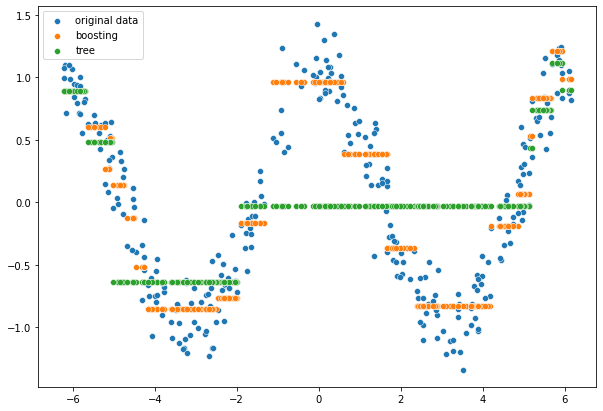

In [ ]:
# генерируем данные
np.random.seed(42)
x = np.random.uniform(low=-2*np.math.pi, high=2*np.math.pi, size=(300))
y = np.cos(x) + np.random.randn(300) * 0.2

# обучаем обычное дерево глубины 3
tree = DecisionTreeRegressor(max_depth=3, random_state=42)
tree.fit(x.reshape(-1, 1), y)

# обучаем наш бустинг-ансамбль
clf = GradientTreeBoosting(iterations=3, max_depth=3, random_state=42)
clf.fit(x.reshape(-1, 1), y)

# визуализация
plt.figure(figsize=(10,7))
sns.scatterplot(x=x, y=y, label='original data')
sns.scatterplot(x=x, y=clf.predict(x.reshape(-1, 1)), label='boosting')
sns.scatterplot(x=x, y=tree.predict(x.reshape(-1, 1)), label='tree')

### Бустинг на практике: прогнозирование оттока пользователей из мобильной сети

Будем решать задачу классификации (sic!), предсказывая, уйдёт ли пользователь мобильной сети или нет.
Задача [отсюда](https://www.kaggle.com/mnassrib/telecom-churn-datasets).

Данные и их типы: 
- State: string
- Account length: integer 
- Area code: integer
- International plan: string
- Voice mail plan: string
- Number vmail messages: integer
- Total day minutes: double
- Total day calls: integer
- Total day charge: double
- Total eve minutes: double
- Total eve calls: integer
- Total eve charge: double
- Total night minutes: double
- Total night calls: integer
- Total night charge: double
- Total intl minutes: double
- Total intl calls: integer
- Total intl charge: double
- Customer service calls: integer
- Churn: string - целевой признак - уйдёт или нет (на самом деле pandas понимает его как булев)

Предсказывать будем логиты, то есть вероятность того, что клиент уйдёт, и на основе её уже делать прогноз, уйдёт ли он на самом деле или нет.

Вам предстоит самостоятельно провести эксперимент. Сравните качество нашей бустинг-модели с обычными методами МО (вспомните и подумайте, какие лучше).

В качестве метрики качества используйте `f1_score` (а ещё лучше, `classification_report`).

#### Загрузите данные и предобработайте их.

Разбейте данные на тренировочную и тестовую подвыборки.

Поскольку деревья из sklearn не поддерживают категориальные признаки, Вам придётся решить эту проблему - попробуйте удалить их _или_ обработать известными нам способами ([one-hot-encoding](https://habr.com/ru/company/ods/blog/326418/#one-hot-encoding), счётчики  и тп).

В описании к датасету предполагалось использовать больший датасет (churn-bigml-80.csv) для обучения, а меньший (churn-bigml-20.csv) для проверки. 


In [ ]:
link ='https://gitlab.7bits.it/coding-garden/coding-garden-ml-data/-/raw/master/data_churn-bigml-80.csv'
df = pd.read_csv(link, sep=',')

df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int64  
 14  Total night charge      2666 non-null   

#### Задание.

Подготовьте признаки в обоих датасетах (churn-bigml-80 и churn-bigml-20): 
- Преобразуйте категориальные признаки
- В датасетах есть частный случай категориального признака, а именно признак бинарный. Значения бинарного признака допустимо преобразовать в целое число (0 или 1), для чего можете использовать логические маски в `pandas` и функцию [`astype`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html). Можете предложить свой вариант.
- Создайте тестовую и тренирочную выборки

Здесь я немного помогу Вам. Функция `test_qual` позволяет проверить качество классификации без лишних телодвижений. Воспользуйтесь ей (если хотите, можете модифицировать как Вам удобно). В исходном виде она не подойдёт для финальной проверки (на разных датасетах), но вы можете сделать промежуточные выводы на её основе.

In [ ]:
def decide_class(logits, threshold=0.5):
    res = np.zeros(logits.shape[0])
    res[logits >= threshold] = 1
    return res

def test_qual(model, X, y, test_size=0.2, threshold=0.5):
    from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, classification_report
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=42)

    model.fit(X_train, y_train)
    test_logits = model.predict(X_test)
    y_pred = decide_class(test_logits, threshold=threshold)

    # print(accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.metrics import classification_report

model = GradientTreeBoosting(random_state=42, max_depth=3)

model.fit(X_test, y_test)
y_pred = decide_class(model.predict(X_train))
print(classification_report(y_pred, y_train))

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       574
         1.0       0.76      0.77      0.77        93

    accuracy                           0.93       667
   macro avg       0.86      0.87      0.86       667
weighted avg       0.93      0.93      0.93       667



In [ ]:
test_qual(GradientTreeBoosting(random_state=42, max_depth=3), X, y)

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       455
           1       0.79      0.63      0.70        79

    accuracy                           0.92       534
   macro avg       0.87      0.80      0.83       534
weighted avg       0.92      0.92      0.92       534



In [ ]:
test_qual(DecisionTreeRegressor(random_state=42, max_depth=3), X, y)

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       455
           1       0.89      0.42      0.57        79

    accuracy                           0.91       534
   macro avg       0.90      0.70      0.76       534
weighted avg       0.91      0.91      0.89       534



In [ ]:
from sklearn.tree import DecisionTreeClassifier
test_qual(DecisionTreeClassifier(random_state=42, max_depth=3), X, y)

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       455
           1       0.89      0.42      0.57        79

    accuracy                           0.91       534
   macro avg       0.90      0.70      0.76       534
weighted avg       0.91      0.91      0.89       534

